In [1]:
# Area under curve for finding step frequecny
# Find step frequencies for continuous segments
# Speed find the running speed in continuous intervals

import Data
from IPython.display import clear_output
from tensorflow.keras import layers
from keras import backend as k
import IPython
import numpy as np
import Data
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import model
from model import build_model_CNN

from plotter import hist_plotter

import os

In [2]:
# Get Data Here
Features_A, Labels, pIDs = Data.dataset_main(150,50,'Yes')
Features_G, Labels, pIDs = Data.dataset_main(150,50,'No')
clear_output()
print('Dataset Loaded')

Dataset Loaded


In [3]:


physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('Could not initialize the tensorflow gpu')
    pass



In [4]:

def R_Square(y_true, y_pred):

    Num = k.sum(k.square(y_true - y_pred))
    Denom = k.sum(k.square(y_true - k.mean(y_true)))
    R = 1 - Num / (Denom + k.epsilon())
    return R


def build_model_CNN():
    inputA = layers.Input(shape=(3, 150, 1))
    modelA = inputA
    min_conv1 = 27
    max_conv1 = 36
    min_conv2 = 36
    max_conv2 = 45
    modelA = layers.Conv2D(27,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(inputA)

    modelA = layers.Conv2D(45,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(modelA)

    #modelA = layers.Flatten()(modelA)
    modelA = layers.GlobalMaxPool2D()(modelA)
    inputG = layers.Input(shape=(3, 150, 1))

    modelG = inputG

    modelG = layers.Conv2D(27,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(inputG)

    modelG = layers.Conv2D(45,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(modelG)

    # model = layers.Dropout(0.4)(model)
    #modelG = layers.Flatten()(modelG)
    modelG = layers.GlobalMaxPool2D()(modelG)
    model = layers.Concatenate()([modelA, modelG])
    #   layers.concatenate(modelA,modelG)

    #model = layers.Dropout(0.4)(model)

    model = layers.Dense(120, activation='relu')(model)

    model = layers.Dropout(0.3)(model)

    model = layers.Dense(30, activation='relu')(model)

    model = layers.Dropout(0.3)(model)

    output = layers.Dense(1)(model)

    model = tf.keras.Model(inputs=[inputA, inputG], outputs=output)

    optimizer = tf.keras.optimizers.RMSprop(1e-3)
    # optimizer = tf.keras.optimizers.Adam(1e-3)

    loss = tf.keras.losses.Huber()
    loss = tf.keras.losses.LogCosh()
    loss = tf.keras.losses.MeanAbsolutePercentageError()
    loss = tf.keras.losses.MeanSquaredError(reduction="auto",
                                            name="mean_squared_error")
    loss = tf.keras.losses.MeanAbsoluteError(name="mean_absolute_error")
    
    model.compile(
        loss=loss,  #'mean_absolute_error',
        optimizer=optimizer,
        metrics=['mae', 'mape', R_Square])

    tf.keras.utils.plot_model(model,
                            #  to_file='/home/redev/Pictures/Model.png',
                              show_shapes=True)
    return model



In [5]:


class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)



earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=50)

reduceLRplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       min_lr=1e-6,
                                                       patience=10,
                                                       factor=0.9,
                                                       verbose=1)

if os.path.isdir('logdir'):
    pass
else:
    os.mkdir('logdir')

logdir = 'logdir'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)



In [6]:
model = build_model_CNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 150, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 150, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 150, 27)   270         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 150, 27)   270         input_2[0][0]                    
______________________________________________________________________________________________

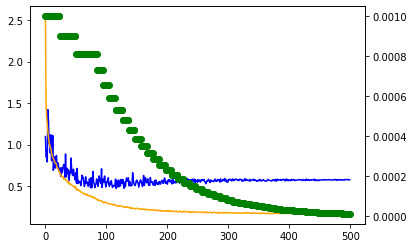

Results of the model training


In [7]:

hist = model.fit(
    [Features_A, Features_G],
    np.array(Labels),
 #   validation_data=([Features_A, Features_G], Labels),
    validation_split = 0.3,
    epochs=500,
    verbose=3,
    callbacks=[
        #        earlystopping,
        reduceLRplateau,
      #  tensorboard_callback,
        ClearTrainingOutput()
    ])

hist_plotter(hist.history)
print("Results of the model training")

In [8]:
print(model.evaluate([Features_A, Features_G], np.array(Labels)))

140/140 [==============================] - 0s 2ms/step - loss: 0.2197 - mae: 0.2197 - mape: 4.6151 - R_Square: -5361.2163
[0.219736710190773, 0.219736710190773, 4.615148067474365, -5361.21630859375]


In [9]:
values = np.hstack((np.array(Labels).reshape(-1,1), np.array(pIDs).reshape(-1,1)))
data_df = pd.DataFrame(values, columns = ['speed', 'person'])

In [10]:
data_df['error'] = 0 

In [ ]:

uniquePID = np.unique(data_df['pIDs'])

uniqueSpeed = np.unique(data_df['speed'])

In [ ]:
uniquePID

In [ ]:
uniqueSpeed

In [ ]:
for up i